In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import entropy
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [53]:
def read_fasta_valid(filepath, max_bases=500000):
    sequence = ''
    valid_bases = {'A', 'C', 'G', 'T'}
    try:
        with open(filepath, 'r') as f:
            for line in f:
                if line.startswith('>'):
                    continue
                line = line.strip().upper()
                for base in line:
                    if base in valid_bases:
                        sequence += base
                        if len(sequence) >= max_bases:
                            return sequence
    except FileNotFoundError:
        print(f"Warning: File {filepath} not found. Generating synthetic sequence.")
        sequence = ''.join(np.random.choice(['A', 'C', 'G', 'T'], size=min(10000, max_bases)))
    return sequence
def generate_cgr(sequence, size=256):
    corners = {'A': (0, 0), 'C': (0, size-1), 'G': (size-1, size-1), 'T': (size-1, 0)}
    x, y = size // 2, size // 2
    image = np.zeros((size, size), dtype=np.uint8)
    for base in sequence:
        if base in corners:
            cx, cy = corners[base]
            x = (x + cx) // 2
            y = (y + cy) // 2
            image[y, x] = 255
    return image

def generate_fcgr(sequence, k=6, size=128):
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    kmer_counts = Counter(kmers)
    corners = {'A': (0, 0), 'C': (0, size-1), 'G': (size-1, size-1), 'T': (size-1, 0)}
    fcgr = np.zeros((size, size))
    for kmer, count in kmer_counts.items():
        x, y = size // 2, size // 2
        for base in kmer:
            if base in corners:
                cx, cy = corners[base]
                x = (x + cx) // 2
                y = (y + cy) // 2
        fcgr[y, x] += count
    if fcgr.max() > 0:
        fcgr = (fcgr / fcgr.max() * 255).astype(np.uint8)
    return fcgr

def generate_multiscale_cgr(sequence, scales=[4, 6, 8], size=256):
    multiscale_features = []
    for k in scales:
        fcgr = generate_fcgr(sequence, k=k, size=size)
        multiscale_features.append(fcgr.flatten())
    return np.concatenate(multiscale_features)


In [54]:
def extract_hog_features(image):
    features, hog_image = hog(image, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True, feature_vector=True)
    return features, hog_image

def extract_lbp_features(image, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
    return hist / hist.sum()

def extract_glcm_features(image, distances=[1], angles=[0, 45, 90, 135]):
    features = []
    angles_rad = [np.radians(angle) for angle in angles]
    for distance in distances:
        glcm = graycomatrix(image, distances=[distance], angles=angles_rad, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast').flatten()
        correlation = graycoprops(glcm, 'correlation').flatten()
        energy = graycoprops(glcm, 'energy').flatten()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten()
        features.extend([contrast.mean(), correlation.mean(), energy.mean(), homogeneity.mean()])
    return np.array(features)

def extract_gabor_features(image, frequencies=[0.1, 0.3, 0.5]):
    features = []
    for freq in frequencies:
        for theta in [0, 45, 90, 135]:
            real, _ = gabor(image, frequency=freq, theta=np.radians(theta))
            features.extend([real.mean(), real.var()])
    return np.array(features)

def extract_statistical_features(image):
    features = [
        image.mean(), image.std(), image.var(),
        np.percentile(image, 25), np.percentile(image, 50),
        np.percentile(image, 75),
        entropy(image.flatten() + 1e-10)
    ]
    return np.array(features)

def extract_comprehensive_features(image):
    hog_features, _ = extract_hog_features(image)
    lbp_features = extract_lbp_features(image)
    glcm_features = extract_glcm_features(image)
    gabor_features = extract_gabor_features(image)
    stat_features = extract_statistical_features(image)
    return np.concatenate([hog_features, lbp_features, glcm_features, gabor_features, stat_features])


In [55]:
def calculate_sequence_properties(sequence):
    length = len(sequence)
    base_counts = Counter(sequence)
    gc_content = (base_counts.get('G', 0) + base_counts.get('C', 0)) / length
    at_content = (base_counts.get('A', 0) + base_counts.get('T', 0)) / length
    dinucs = [sequence[i:i+2] for i in range(length-1)]
    dinuc_counts = Counter(dinucs)
    cg_observed = dinuc_counts.get('CG', 0)
    c_count = base_counts.get('C', 0)
    g_count = base_counts.get('G', 0)
    cg_expected = (c_count * g_count) / length if length > 0 else 0
    cpg_ratio = cg_observed / cg_expected if cg_expected > 0 else 0
    base_probs = np.array([base_counts.get(base, 0) for base in 'ACGT']) / length
    base_probs = base_probs[base_probs > 0]
    seq_entropy = -np.sum(base_probs * np.log2(base_probs))
    return {
        'length': length, 'gc_content': gc_content, 'at_content': at_content,
        'cpg_ratio': cpg_ratio, 'entropy': seq_entropy, 'base_counts': dict(base_counts)
    }



In [56]:
def compute_similarity_matrix(feature_vectors, labels, metric='euclidean'):
    distances = pdist(feature_vectors, metric=metric)
    distance_matrix = squareform(distances)
    df = pd.DataFrame(distance_matrix, index=labels, columns=labels)
    return df, distance_matrix

def compute_multiple_distances(feature_vectors, labels):
    metrics = {
        'euclidean': 'euclidean',
        'cosine': 'cosine',
        'manhattan': 'cityblock',    # FIXED
        'chebyshev': 'chebyshev'
    }
    
    distance_results = {}
    for name, metric in metrics.items():
        df, matrix = compute_similarity_matrix(feature_vectors, labels, metric)
        distance_results[name] = {'dataframe': df, 'matrix': matrix}
    
    return distance_results



In [57]:
class CGRAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA()
        self.classifier = SVC(kernel='rbf', random_state=42)
        self.clusterer = KMeans(random_state=42)

    def fit_transform_features(self, features):
        scaled_features = self.scaler.fit_transform(features)
        pca_features = self.pca.fit_transform(scaled_features)
        return scaled_features, pca_features

    def perform_classification(self, features, labels):
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels)
        self.classifier.fit(X_train, y_train)
        y_pred = self.classifier.predict(X_test)
        cv_scores = cross_val_score(self.classifier, features, labels, cv=3)
        return {
            'test_accuracy': self.classifier.score(X_test, y_test),
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

    def perform_clustering(self, features, n_clusters=4):
        self.clusterer.n_clusters = n_clusters
        cluster_labels = self.clusterer.fit_predict(features)
        sil_score = silhouette_score(features, cluster_labels)
        return {
            'cluster_labels': cluster_labels,
            'silhouette_score': sil_score,
            'inertia': self.clusterer.inertia_,
            'cluster_centers': self.clusterer.cluster_centers_
        }



In [58]:
def plot_cgr_comparison(cgr_images, titles):
    n_images = len(cgr_images)
    fig, axes = plt.subplots(1, n_images, figsize=(4*n_images, 4))
    if n_images == 1: axes = [axes]
    for i, (img, title) in enumerate(zip(cgr_images, titles)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_svm_decision_boundary(X_pca, y, classifier, labels=None):
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=100)

    if labels:
        for i, label in enumerate(labels):
            plt.annotate(label, (X_pca[i, 0] + 0.05, X_pca[i, 1] + 0.05), fontsize=9)

    plt.title("SVM Decision Boundary (PCA-reduced Features)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()


def plot_distance_heatmap(distance_df, title="Distance Matrix"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_df, annot=True, cmap='viridis', fmt='.3f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_pca_analysis(pca_features, labels, pca_object):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    unique_labels = list(set(labels))
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        mask = np.array(labels) == label
        ax1.scatter(pca_features[mask, 0], pca_features[mask, 1], c=[colors[i]], label=label, alpha=0.7, s=100)
    ax1.set_xlabel(f'PC1 ({pca_object.explained_variance_ratio_[0]:.2%})')
    ax1.set_ylabel(f'PC2 ({pca_object.explained_variance_ratio_[1]:.2%})')
    ax1.set_title('PCA Scatter Plot')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    cumsum_var = np.cumsum(pca_object.explained_variance_ratio_)
    ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('Explained Variance')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_dendrogram(distance_matrix, labels, method='ward'):
    linkage_matrix = linkage(distance_matrix, method=method)
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=labels, orientation='top')
    plt.title(f'Dendrogram ({method} linkage)')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [63]:
def comprehensive_cgr_analysis(samples_dict, max_bases=500000):
    print("=" * 60)
    print("COMPREHENSIVE CGR ANALYSIS FOR BIOLOGICAL SEQUENCES")
    print("=" * 60)

    sequences, cgr_images, fcgr_images, feature_vectors, sequence_properties = {}, {}, {}, {}, {}

    for name, path in samples_dict.items():
        print(f"\nProcessing {name}...")
        sequence = read_fasta_valid(path, max_bases)
        sequences[name] = sequence
        print(f"  Sequence length: {len(sequence)}")
        props = calculate_sequence_properties(sequence)
        sequence_properties[name] = props
        print(f"  GC Content: {props['gc_content']:.3f} | Entropy: {props['entropy']:.3f}")
        cgr_img = generate_cgr(sequence)
        fcgr_img = generate_fcgr(sequence)
        cgr_images[name] = cgr_img
        fcgr_images[name] = fcgr_img
        features = extract_comprehensive_features(cgr_img)
        feature_vectors[name] = features

    sample_names = list(samples_dict.keys())
    feature_matrix = np.array([feature_vectors[name] for name in sample_names])

    plot_cgr_comparison([cgr_images[n] for n in sample_names], [f"CGR: {n}" for n in sample_names])
    plot_cgr_comparison([fcgr_images[n] for n in sample_names], [f"FCGR: {n}" for n in sample_names])

    print("\nComputing Distance Matrices...")
    distance_results = compute_multiple_distances(feature_matrix, sample_names)
    for metric, result in distance_results.items():
        plot_distance_heatmap(result['dataframe'], f"{metric.capitalize()} Distance Matrix")

    print("\nMACHINE LEARNING ANALYSIS")
    analyzer = CGRAnalyzer()
    scaled_features, pca_features = analyzer.fit_transform_features(feature_matrix)
    plot_pca_analysis(pca_features, sample_names, analyzer.pca)
    print(f"  - First 2 PCs: {analyzer.pca.explained_variance_ratio_[:2].sum():.2%}")

    clustering_results = analyzer.perform_clustering(scaled_features, n_clusters=min(3, len(sample_names) - 1))

    # Define binary labels: 1 = Pathogenic, 0 = Non-Pathogenic
    binary_labels = [1, 0, 1, 0, 1, 0]  # Ensure this matches sample_names order

    print("\nRunning SVM Classification...")
    classification_results = analyzer.perform_classification(scaled_features, binary_labels)

       # ✅ Train a separate SVM on 2D PCA features only for plotting
    svm_pca_vis = SVC(kernel='rbf', random_state=42)
    svm_pca_vis.fit(pca_features[:, :2], binary_labels)
    plot_svm_decision_boundary(pca_features[:, :2], binary_labels, svm_pca_vis, labels=sample_names)


    # Print classification metrics
    print(f"  - Test Accuracy: {classification_results['test_accuracy']:.3f}")
    print(f"  - CV Mean Accuracy: {classification_results['cv_mean']:.3f} ± {classification_results['cv_std']:.3f}")
    print("\nClassification Report:\n", classification_results['classification_report'])
    print("Confusion Matrix:\n", classification_results['confusion_matrix'])

    print(f"  - Silhouette Score: {clustering_results['silhouette_score']:.3f}")
    print(f"  - Cluster Assignments: {dict(zip(sample_names, clustering_results['cluster_labels']))}")
    plot_dendrogram(distance_results['euclidean']['matrix'], sample_names)

    print("\nSEQUENCE PROPERTIES SUMMARY")
    print(pd.DataFrame(sequence_properties).T.round(3))
    print(f"\nFeature Matrix Shape: {feature_matrix.shape}")

    return {
        'sequences': sequences,
        'cgr_images': cgr_images,
        'fcgr_images': fcgr_images,
        'feature_vectors': feature_vectors,
        'feature_matrix': feature_matrix,
        'sequence_properties': sequence_properties,
        'distance_results': distance_results,
        'pca_features': pca_features,
        'clustering_results': clustering_results,
        'analyzer': analyzer,
        'classification_results': classification_results
    }


COMPREHENSIVE CGR ANALYSIS FOR BIOLOGICAL SEQUENCES

Processing Polio Virus...
  Sequence length: 7440
  GC Content: 0.463 | Entropy: 1.992

Processing Entero Virus C611...
  Sequence length: 7394
  GC Content: 0.433 | Entropy: 1.984

Processing Hepatitis A Virus...
  Sequence length: 7478
  GC Content: 0.379 | Entropy: 1.949

Processing Simian HAV Virus...
  Sequence length: 7425
  GC Content: 0.383 | Entropy: 1.952

Processing Aichi Virus...
  Sequence length: 8251
  GC Content: 0.589 | Entropy: 1.942

Processing Kobu Virus...
  Sequence length: 8216
  GC Content: 0.584 | Entropy: 1.946


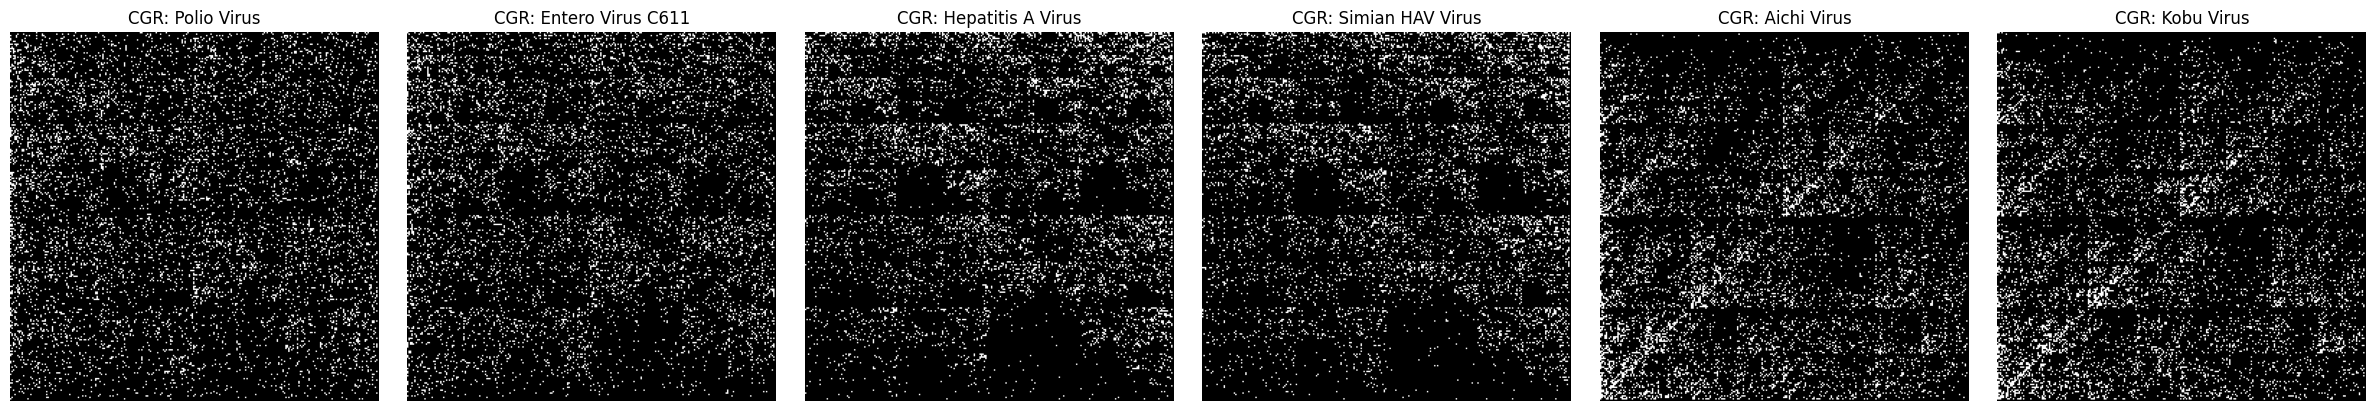

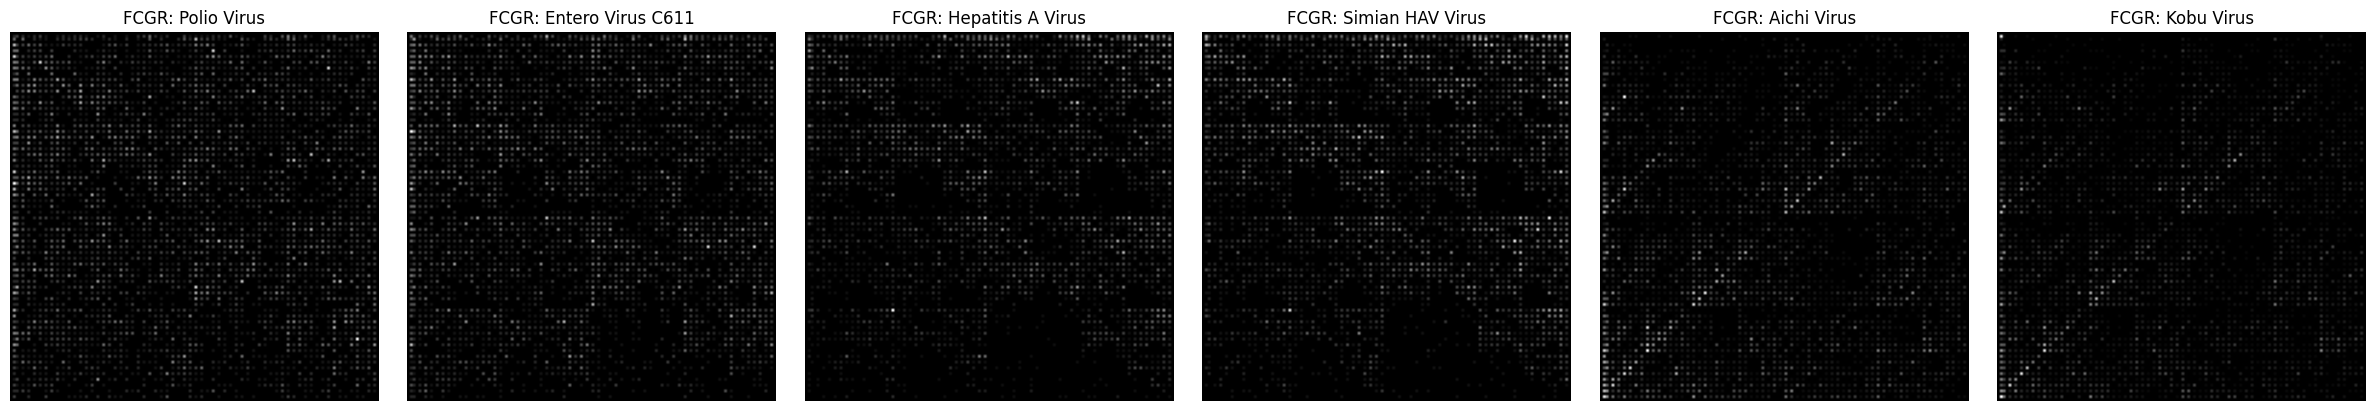


Computing Distance Matrices...


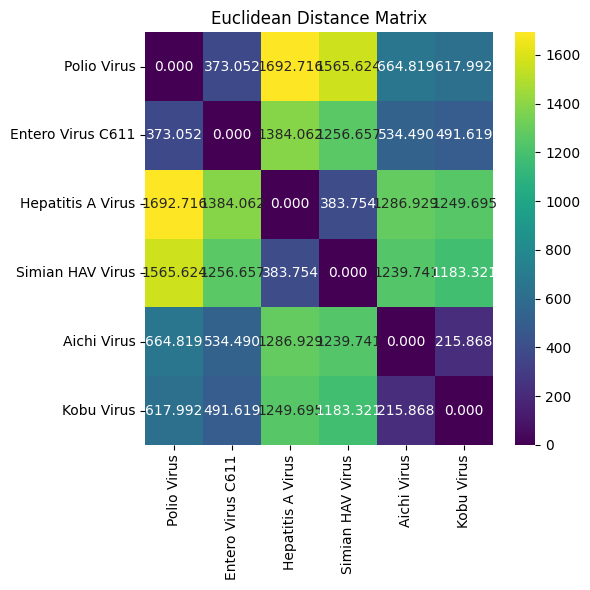

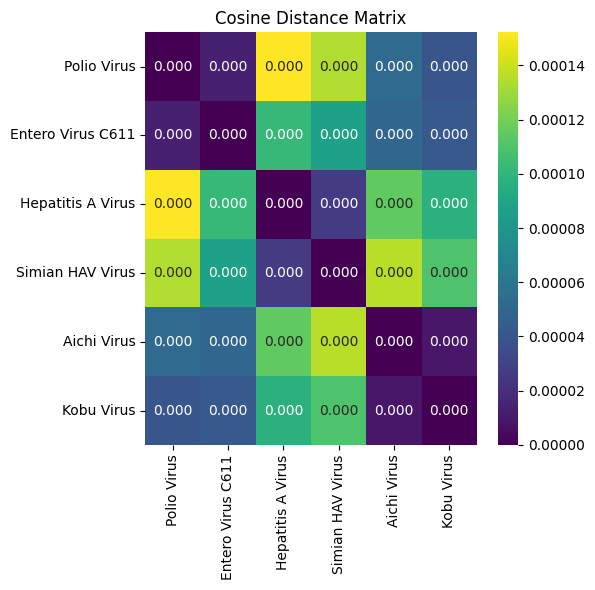

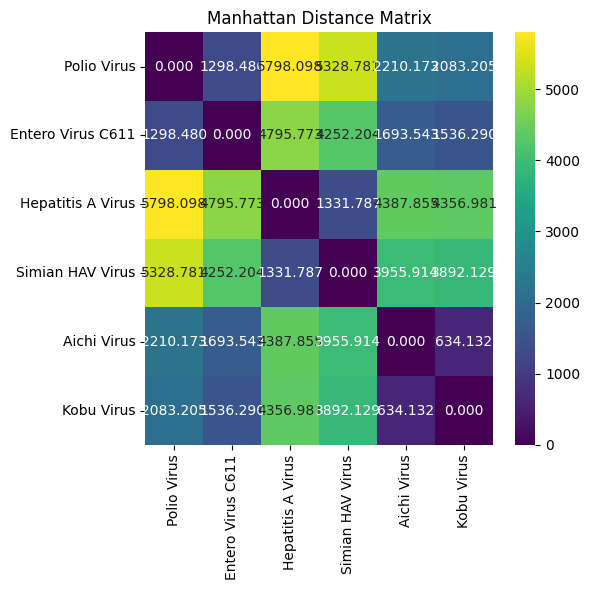

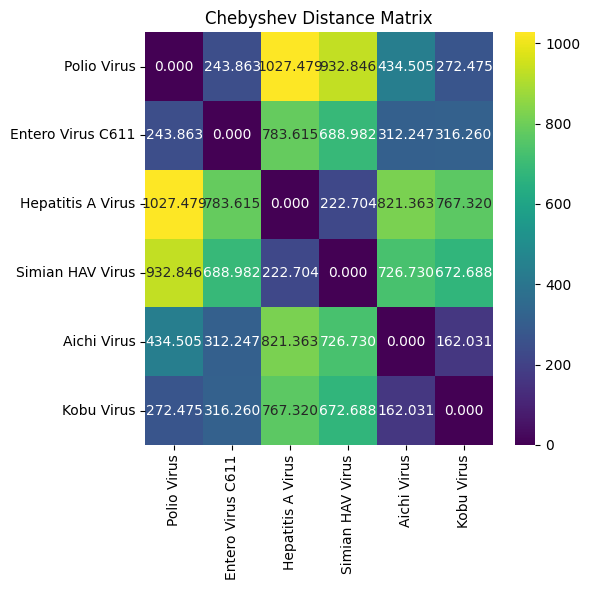


MACHINE LEARNING ANALYSIS


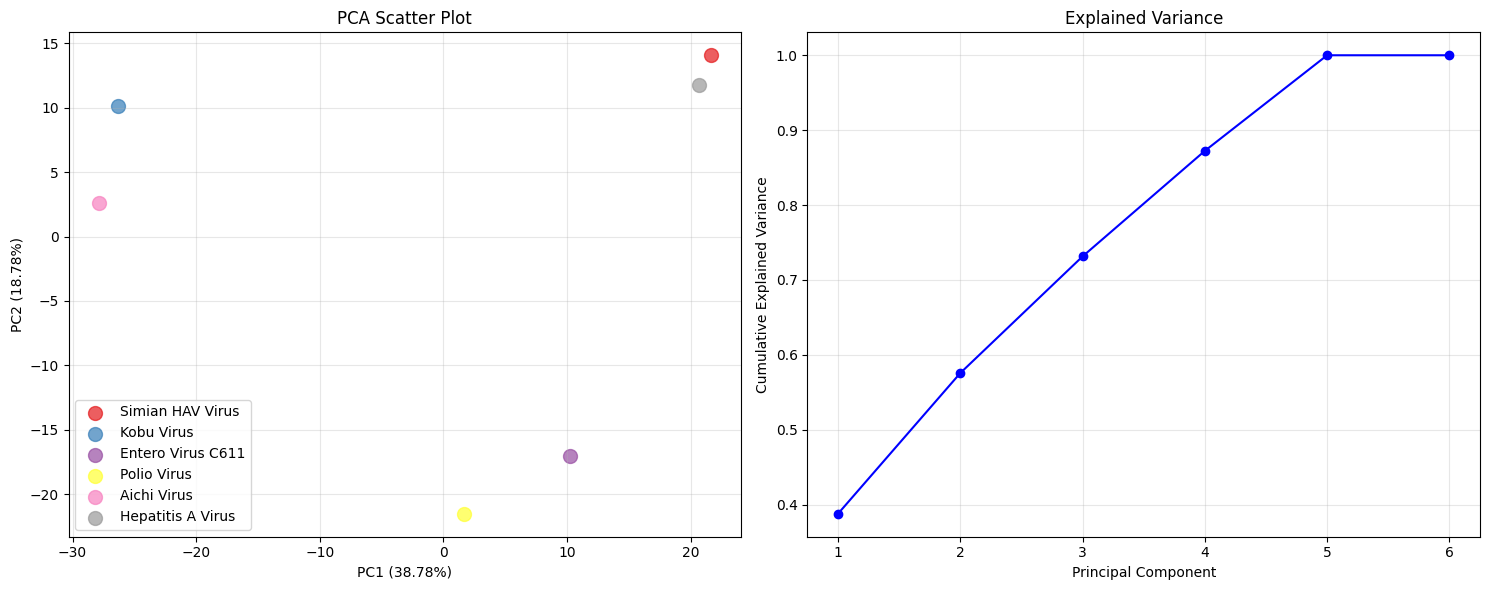

  - First 2 PCs: 57.57%

Running SVM Classification...


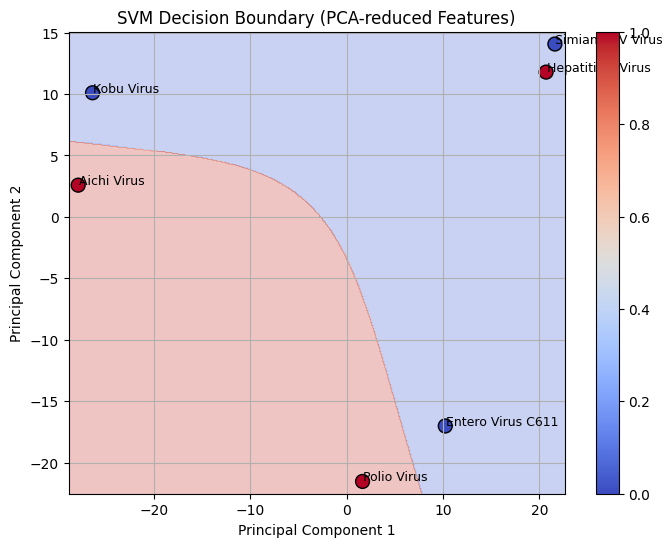

  - Test Accuracy: 0.000
  - CV Mean Accuracy: 0.333 ± 0.236

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Confusion Matrix:
 [[0 1]
 [1 0]]
  - Silhouette Score: 0.117
  - Cluster Assignments: {'Polio Virus': np.int32(2), 'Entero Virus C611': np.int32(2), 'Hepatitis A Virus': np.int32(0), 'Simian HAV Virus': np.int32(0), 'Aichi Virus': np.int32(1), 'Kobu Virus': np.int32(1)}


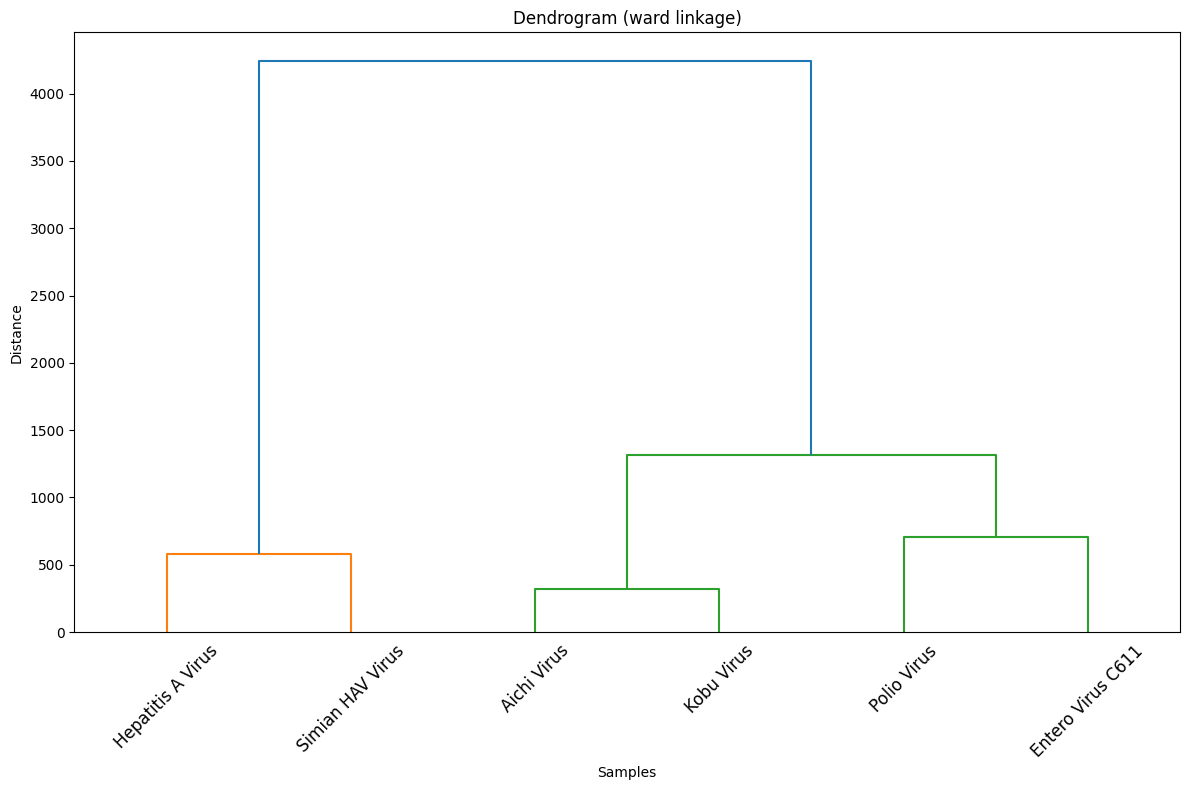


SEQUENCE PROPERTIES SUMMARY
                  length gc_content at_content cpg_ratio   entropy  \
Polio Virus         7440   0.463441   0.536559  0.538222  1.991829   
Entero Virus C611   7394   0.433189   0.566811  0.369014  1.984335   
Hepatitis A Virus   7478   0.378577   0.621423  0.148945  1.949269   
Simian HAV Virus    7425     0.3833     0.6167  0.150263   1.95165   
Aichi Virus         8251    0.58902    0.41098  0.757641  1.941896   
Kobu Virus          8216   0.583861   0.416139  0.719396  1.945564   

                                                    base_counts  
Polio Virus        {'T': 1786, 'A': 2206, 'C': 1737, 'G': 1711}  
Entero Virus C611  {'T': 1924, 'C': 1608, 'A': 2267, 'G': 1595}  
Hepatitis A Virus  {'T': 2459, 'C': 1202, 'A': 2188, 'G': 1629}  
Simian HAV Virus   {'C': 1203, 'T': 2445, 'G': 1643, 'A': 2134}  
Aichi Virus        {'T': 1783, 'C': 3116, 'A': 1608, 'G': 1744}  
Kobu Virus         {'T': 1771, 'A': 1648, 'G': 1725, 'C': 3072}  

Feature Matrix Sh

In [65]:
if __name__ == "__main__":
    samples = {
        "Polio Virus":"polioVirus.fasta", #Pathogenic
        "Entero Virus C611":"humanEnteroVirus.fasta", #Non Pathogenic
        "Hepatitis A Virus":"hepatitisAVirus.fasta", #Pathogenic
        "Simian HAV Virus":"simianNonPath.fasta", #Non Pathogenic
        "Aichi Virus":"aichiVirus.fasta", #Pathogenic
        "Kobu Virus":"kobuVirus.fasta" #Non Pathogenic
    }
    results = comprehensive_cgr_analysis(samples)
    print("\nResults dictionary containas:")
    for key in results:
        print(f"  - {key}")

